In [1]:
import tifffile as tiff
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import UTXCTregister as reg

In [2]:
from tqdm import tqdm
def write_sequence(folder_path, name, volume):
    """
    Save a 3D volume as a sequence of TIFF files in a folder.
    
    Args:
    folder_path (str): Path to the folder where TIFF files will be saved.
    name (str): Name of the TIFF files.
    volume (numpy.ndarray): A 3D array where each slice corresponds to an image.
    """

    folder_path = folder_path / name

    # Create the folder if it doesn't exist
    Path(folder_path).mkdir(parents=True, exist_ok=True)

    # Save each slice as a TIFF file with progress bar
    with tqdm(total=volume.shape[0], desc="Saving") as pbar:
        for i in range(volume.shape[0]):
            tiff.imwrite(f"{folder_path}/{name}_{i:04d}.tif", volume[i])
            pbar.update(1)
    
    print("Saving complete.")


In [3]:
folder = Path(r'Q:\11_AIRBUS\03_LabXCT\Panel Pegaso\Probetas\1\24\registration_auxiliary_files')

ut = tiff.imread(Path(r'\\192.168.10.106\imdea\DataDriven_UT_AlbertoVicente\03_UT_data\Panel PEGASO\probetas\1\24\24_lente_amplitude.tif'))

xct = tiff.imread(Path(r'Q:\11_AIRBUS\03_LabXCT\Panel Pegaso\Probetas\1\24\frontal_90right_cropped.tif'))

xct = np.swapaxes(xct, 0, 1)
xct = np.swapaxes(xct, 1, 2)

ut = np.swapaxes(ut, 0, 1)
ut = np.swapaxes(ut, 1, 2)

In [4]:
xct_registered = reg.main(ut,xct)

Preprocessing
Preprocessed
Registering
Registered
Applying transformation
Big shape: (5040, 1920)
Transformation applied


In [7]:
write_sequence(folder, 'xct_registered', xct_registered)

Saving: 100%|██████████| 325/325 [00:34<00:00,  9.55it/s]

Saving complete.


In [59]:
ut_centers = reg.label_objects(reg.ut_preprocessing(ut))

xct_centers = reg.label_objects(reg.xct_preprocessing(xct))

In [60]:

def paste_on_canvas(image, shape):
    """
    Paste an image on a canvas of a given shape, centered.
    
    Args:
    image (numpy.ndarray): A 2D array representing an image.
    shape (tuple): Shape of the canvas.
    
    Returns:
    numpy.ndarray: A 2D array representing the canvas with the image pasted on it.
    """
    
    canvas = np.zeros(shape, dtype=image.dtype)
    
    # Calculate the starting indices to center the image
    start_row = (shape[0] - image.shape[0]) // 2
    start_col = (shape[1] - image.shape[1]) // 2
    
    # Paste the image onto the canvas
    canvas[start_row:start_row + image.shape[0], start_col:start_col + image.shape[1]] = image
    
    return canvas

def extract_points(image): #given a points image, returns the list of points in it x,y,value
    points = []
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i,j] > 0:
                points.append([i,j,image[i,j]])
    return np.array(points)

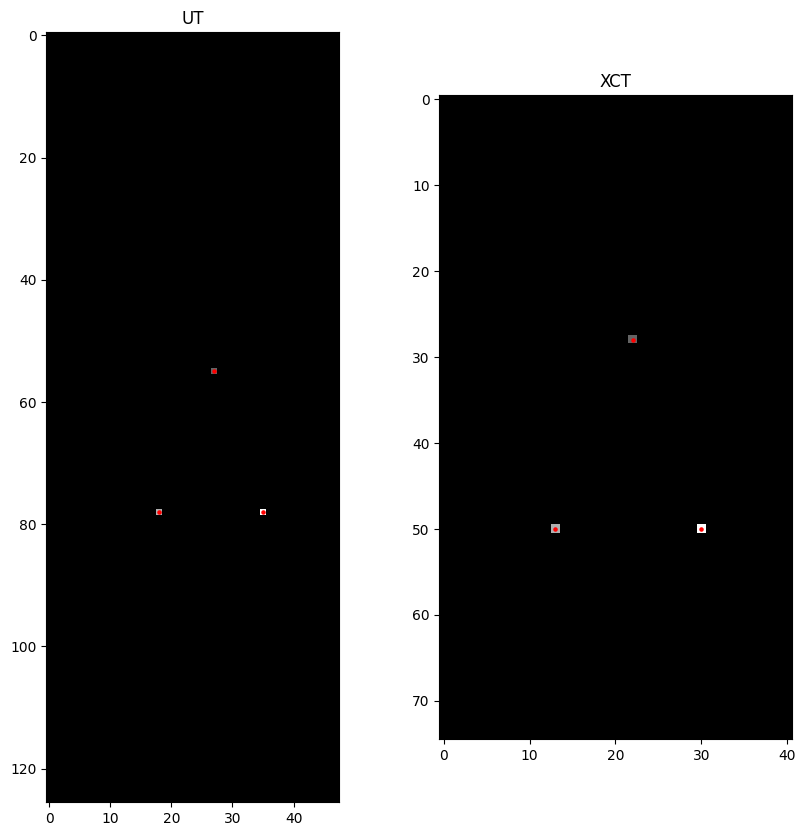

Ut_points: [[ 55  27 100]
 [ 78  18 175]
 [ 78  35 255]]
Xct_points: [[ 28  22 100]
 [ 50  13 175]
 [ 50  30 255]]


In [61]:
#extract the points from the images
ut_points = extract_points(ut_centers)
xct_points = extract_points(xct_centers)

sorted_indices_ut = np.argsort(ut_points[:, -1])
sorted_indices_xct = np.argsort(xct_points[:, -1])

# Use these indices to sort the original array
sorted_ut_points = ut_points[sorted_indices_ut]
sorted_xct_points = xct_points[sorted_indices_xct]

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(ut_centers, cmap='gray')
plt.scatter(sorted_ut_points[:, 1], sorted_ut_points[:, 0], c='r', s=5)
plt.title('UT')

plt.subplot(1, 2, 2)
plt.imshow(xct_centers, cmap='gray')
plt.scatter(sorted_xct_points[:, 1], sorted_xct_points[:, 0], c='r', s=5)
plt.title('XCT')

plt.show()

print('Ut_points:', sorted_ut_points)
print('Xct_points:', sorted_xct_points)

In [62]:
#check if there are at least 2 points
if len(sorted_ut_points) < 2 or len(sorted_xct_points) < 2:
    print('Not enough points')
    #aqui ira un raise error en la funcion

#check if there are the same number of points
if len(sorted_ut_points) != len(sorted_xct_points):
    print('Different number of points')
    #aqui ira un raise error en la funcion

In [63]:
import numpy as np

def get_rotation_angle(transformation_matrix):
    """
    Extract the rotation angle from the transformation matrix.
    
    Args:
    transformation_matrix (numpy.ndarray): A 3x3 transformation matrix.
    
    Returns:
    float: The rotation angle in radians.
    """
    R = transformation_matrix[:2, :2]
    angle = np.arctan2(R[1, 0], R[0, 0])
    return angle

def rigid_body_transformation_matrix(points_A, points_B):
    """
    Calculate the rigid body transformation matrix to convert points_B to points_A.
    
    Args:
    points_A (numpy.ndarray): A Nx2 array of points.
    points_B (numpy.ndarray): A Nx2 array of points.
    
    Returns:
    numpy.ndarray: A 3x3 transformation matrix.
    """
    
    # Compute the centroids of both sets of points
    centroid_A = np.mean(points_A, axis=0)
    centroid_B = np.mean(points_B, axis=0)
    
    # Center the points by subtracting the centroids
    centered_A = points_A - centroid_A
    centered_B = points_B - centroid_B
    
    # Compute the covariance matrix
    H = np.dot(centered_B.T, centered_A)
    
    # Perform Singular Value Decomposition (SVD)
    U, S, Vt = np.linalg.svd(H)
    
    # Compute the rotation matrix
    R = np.dot(Vt.T, U.T)
    
    # Ensure a right-handed coordinate system
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = np.dot(Vt.T, U.T)
    
    # Compute the translation vector
    t = centroid_A - np.dot(R, centroid_B)
    
    # Construct the transformation matrix
    transformation_matrix = np.eye(3)
    transformation_matrix[:2, :2] = R
    transformation_matrix[:2, 2] = t
    
    return transformation_matrix

def scale_transformation_matrix(transformation_matrix, scale_factor):
    """
    Scale a 2D rigid body transformation matrix.
    
    Args:
    transformation_matrix (numpy.ndarray): A 3x3 transformation matrix.
    scale_factor (float): Scaling factor.
    
    Returns:
    numpy.ndarray: A 3x3 scaled transformation matrix.
    """
    
    # Construct the scaling matrix
    scaled_transformation_matrix = transformation_matrix.copy()

    scaled_transformation_matrix[:2,2] *= scale_factor


    return scaled_transformation_matrix

def convert_2d_to_3d(transformation_matrix_2d):
    """
    Convert a 2D transformation matrix to a 3D transformation matrix.
    
    Args:
    transformation_matrix_2d (numpy.ndarray): A 3x3 2D transformation matrix.
    
    Returns:
    numpy.ndarray: A 4x4 3D transformation matrix.
    """
    # Initialize a 4x4 identity matrix
    transformation_matrix_3d = np.eye(4)
    
    # Copy the 2D transformation matrix into the 3D transformation matrix
    transformation_matrix_3d[:2, :2] = transformation_matrix_2d[:2, :2]
    transformation_matrix_3d[:2, 3] = transformation_matrix_2d[:2, 2]
    
    return transformation_matrix_3d

    
    # Apply the

transformation_matrix = rigid_body_transformation_matrix(sorted_xct_points[:,:2],sorted_ut_points[:,:2])
scaled_transformation_matrix = scale_transformation_matrix(transformation_matrix, 1/0.025)
transformation_matrix_3d = convert_2d_to_3d(scaled_transformation_matrix)
print('Transformation matrix:', transformation_matrix)
print('Scaled transformation matrix:', scaled_transformation_matrix)
print('Transformation matrix 3D:', transformation_matrix_3d)

Transformation matrix: [[ 9.99999761e-01  6.91562767e-04 -2.76850915e+01]
 [-6.91562767e-04  9.99999761e-01 -4.95135371e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Scaled transformation matrix: [[ 9.99999761e-01  6.91562767e-04 -1.10740366e+03]
 [-6.91562767e-04  9.99999761e-01 -1.98054148e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Transformation matrix 3D: [[ 9.99999761e-01  6.91562767e-04  0.00000000e+00 -1.10740366e+03]
 [-6.91562767e-04  9.99999761e-01  0.00000000e+00 -1.98054148e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [64]:
import scipy.ndimage

# Apply the affine transformation
transformed_image = scipy.ndimage.affine_transform(xct_centers, transformation_matrix[:2,:], output_shape=ut_centers.shape)

Rotation angle: -0.0006915628219780427


In [65]:
transformed_volume = reg.apply_transform_parameters(angle,transformation_matrix[0,2],transformation_matrix[1,2],ut,xct)

In [66]:
big_shape = reg.calculate_new_dimensions(1,0.025,ut_centers.shape)

print('Big shape:', big_shape)

transformed_volume = []

for i in tqdm(range(xct.shape[2])):
    transformed_volume.append(scipy.ndimage.affine_transform(xct[:,:,i], scaled_transformation_matrix[:2,:], output_shape=big_shape))

transformed_volume = np.array(transformed_volume)

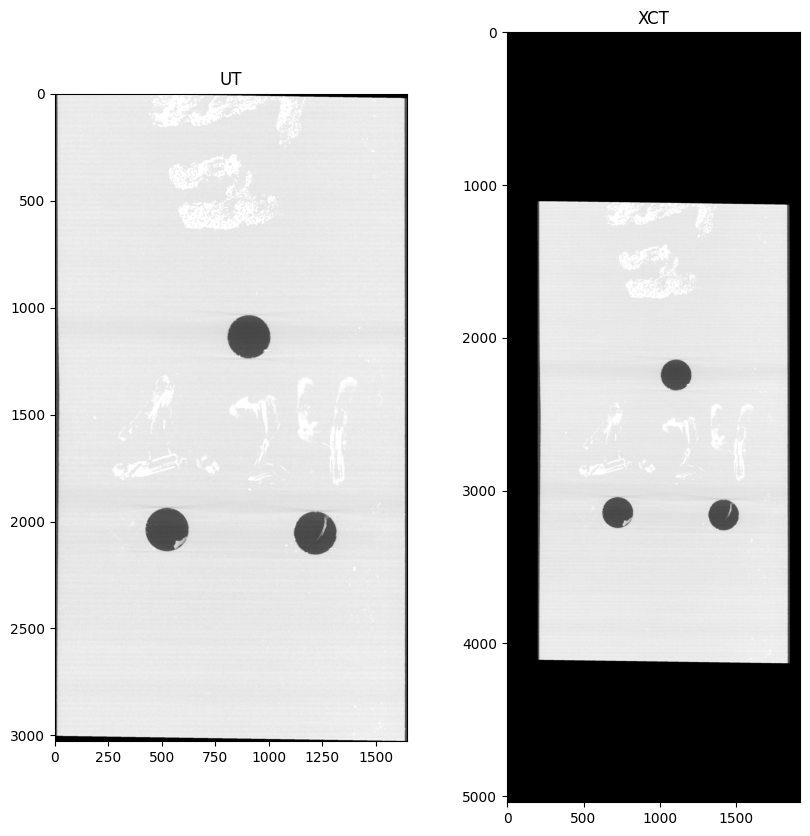

In [67]:
# big_shape = reg.calculate_new_dimensions(1,0.025,ut_centers.shape)

# proj_a = np.max(xct, axis=2)

# proj_b = scipy.ndimage.affine_transform(proj_a, scaled_transformation_matrix[:2,:], output_shape=big_shape)

# plt.figure(figsize=(10, 10))

# plt.subplot(1, 2, 1)
# plt.imshow(proj_a, cmap='gray')
# plt.title('UT')

# plt.subplot(1, 2, 2)
# plt.imshow(proj_b, cmap='gray')
# plt.title('XCT')

# plt.show()

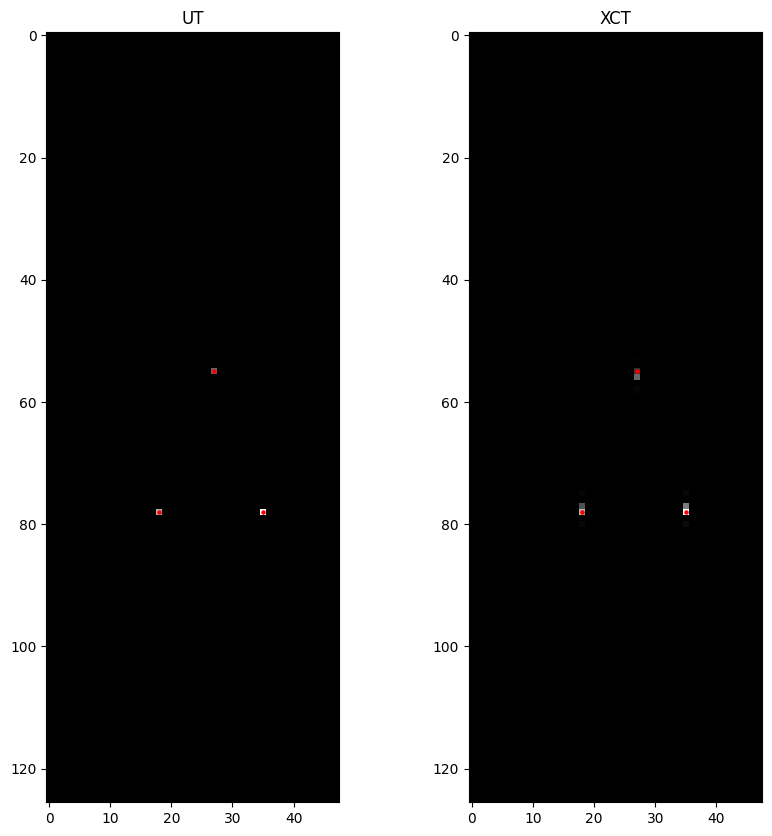

In [68]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(ut_centers, cmap='gray')
plt.scatter(sorted_ut_points[:, 1], sorted_ut_points[:, 0], c='r', s=5)
plt.title('UT')

plt.subplot(1, 2, 2)
plt.imshow(transformed_image, cmap='gray')
plt.scatter(ut_points[:, 1], ut_points[:, 0], c='r', s=5)
plt.title('XCT')

plt.show()

In [69]:
tiff.imsave(folder / 'a.tif', proj_b)

C:\Users\alberto.vicente\AppData\Local\Temp\ipykernel_9440\2718407791.py:1: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(folder / 'a.tif', proj_b)
